# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint
import seaborn as sn

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

622

In [3]:
# Look at type of response.
type(cities)

list

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
#Get first city on the list
firstCity = cities[0]
firstCity


'sirnak'

In [5]:
# Build query URL to get first city
units = "imperial"
url = f"http://api.openweathermap.org/data/2.5/weather?q={firstCity}&appid={weather_api_key}&units={units}"
url

'http://api.openweathermap.org/data/2.5/weather?q=sirnak&appid=beba4513f45a453a59fc584a9cb8e4bc&units=imperial'

In [6]:
# Pretty print output of the json
response = requests.get(url).json()
pprint(response)


{'base': 'stations',
 'clouds': {'all': 100},
 'cod': 200,
 'coord': {'lat': 37.52, 'lon': 42.46},
 'dt': 1588550028,
 'id': 300640,
 'main': {'feels_like': 40.89,
          'grnd_level': 859,
          'humidity': 50,
          'pressure': 1013,
          'sea_level': 1013,
          'temp': 48.09,
          'temp_max': 48.09,
          'temp_min': 48.09},
 'name': 'Şırnak',
 'sys': {'country': 'TR', 'sunrise': 1588558277, 'sunset': 1588608147},
 'timezone': 10800,
 'weather': [{'description': 'overcast clouds',
              'icon': '04n',
              'id': 804,
              'main': 'Clouds'}],
 'wind': {'deg': 55, 'speed': 6.02}}


In [7]:
response["clouds"]["all"]

100

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [8]:
# Set empty lists to hold city data
lats = []
longs = []
temps = []
humids = []
pressures = []
winds = []
clouds = []

cities_list = []
counter = 0

# Loop through each city
for city in cities:
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={weather_api_key}&units={units}"
    
    try:
        response = requests.get(url).json()
    
        code = response["cod"]
    
        if code == 200:
            cities_list.append(city)
            lats.append(response["coord"]["lat"])
            longs.append(response["coord"]["lon"])
            temps.append(response["main"]["temp"])
            humids.append(response["main"]["humidity"])
            pressures.append(response["main"]["pressure"])
        
            winds.append(response["wind"]["speed"])
            clouds.append(response["clouds"]["all"])
        
        if counter % 50 == 0:
           print(counter)
    
    except Exception as e:
        print(e)
        
    counter += 1
    time.sleep(1)


0
50
100
150
200
250
300
350
400
450
500
550
600


In [ ]:
counter

In [10]:
# Create data frame

city_data_df = pd.DataFrame()
city_data_df["cities"] = cities_list
city_data_df["latitude"] = lats
city_data_df["longitude"] = longs
city_data_df["temperature"] = temps
city_data_df["humidity"] = humids
city_data_df["pressure"] = pressures
city_data_df["wind_speed"] = winds
city_data_df["cloudiness"] = clouds

city_data_df.head(10)

,cities,latitude,longitude,temperature,humidity,pressure,wind_speed,cloudiness
0,sirnak,37.52,42.46,48.09,50,1013,6.02,100
1,bundaberg,-24.85,152.35,66.31,48,1021,9.17,90
2,atuona,-9.80,-139.03,82.04,73,1010,17.40,13
3,port elizabeth,-33.92,25.57,59.00,100,1025,4.70,90
4,qaanaaq,77.48,-69.36,20.88,88,997,2.82,97
5,oktyabrskiy,54.48,53.47,39.49,69,1024,2.51,0
6,kodiak,57.79,-152.41,57.20,28,1003,16.11,1
7,khatanga,71.97,102.50,11.71,95,1017,6.98,99
8,taltal,-25.40,-70.48,59.61,76,1015,2.28,22
9,cape town,-33.93,18.42,54.61,87,1021,2.24,85


In [11]:
len(city_data_df)

565

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [12]:
city_data_df.describe()

,latitude,longitude,temperature,humidity,pressure,wind_speed,cloudiness
count,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000
mean,20.247292,21.248372,61.752460,69.787611,1012.665487,7.736531,52.502655
std,33.270338,89.557417,18.376005,21.974942,6.535470,5.195811,37.777748
min,-54.800000,-179.170000,10.220000,10.000000,989.000000,0.220000,0.000000
25%,-8.100000,-54.330000,49.170000,56.000000,1009.000000,3.530000,17.000000
50%,22.850000,26.890000,65.080000,75.000000,1012.000000,6.490000,55.000000
75%,48.650000,100.340000,77.220000,87.000000,1017.000000,11.010000,90.000000
max,78.220000,178.420000,90.880000,100.000000,1041.000000,28.860000,100.000000


In [13]:
#  Get the indices of cities that have humidity over 100%.
# Filter cities with humidity under  or equal to 100 and reset the index.
mask = city_data_df.humidity <= 100
city_data_df_sub = city_data_df.loc[mask].reset_index(drop = True)

city_data_df_sub.head()

,cities,latitude,longitude,temperature,humidity,pressure,wind_speed,cloudiness
0,sirnak,37.52,42.46,48.09,50,1013,6.02,100
1,bundaberg,-24.85,152.35,66.31,48,1021,9.17,90
2,atuona,-9.80,-139.03,82.04,73,1010,17.40,13
3,port elizabeth,-33.92,25.57,59.00,100,1025,4.70,90
4,qaanaaq,77.48,-69.36,20.88,88,997,2.82,97


In [14]:
# Export the City_Data into a csv
city_data_df_sub.to_csv("cityData.csv", index=False)

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [15]:
# Read csv file
cityData_df = pd.read_csv("cityData.csv")

cityData_df.head()

,cities,latitude,longitude,temperature,humidity,pressure,wind_speed,cloudiness
0,sirnak,37.52,42.46,48.09,50,1013,6.02,100
1,bundaberg,-24.85,152.35,66.31,48,1021,9.17,90
2,atuona,-9.80,-139.03,82.04,73,1010,17.40,13
3,port elizabeth,-33.92,25.57,59.00,100,1025,4.70,90
4,qaanaaq,77.48,-69.36,20.88,88,997,2.82,97


## Latitude vs. Temperature Plot

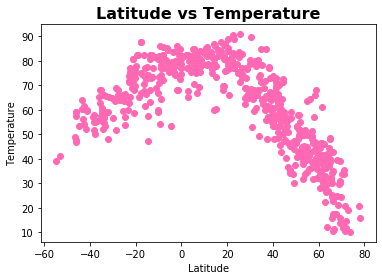

In [16]:
# Create scatter plot
plt.scatter(cityData_df.latitude, cityData_df.temperature, color="hotpink")

#Set title and labels 
plt.xlabel("Latitude")
plt.ylabel("Temperature")
plt.title("Latitude vs Temperature", fontsize=16, fontweight="bold")
plt.show()

## Latitude vs. Humidity Plot

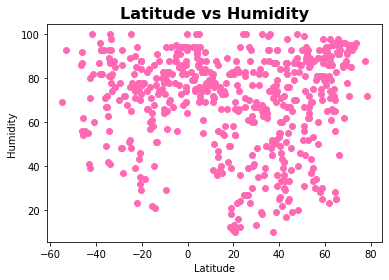

In [17]:
# Create scatter plot
plt.scatter(cityData_df.latitude, cityData_df.humidity, color="hotpink")

#Set title and labels 
plt.xlabel("Latitude")
plt.ylabel("Humidity")
plt.title("Latitude vs Humidity", fontsize=16, fontweight="bold")
plt.show()

## Latitude vs. Cloudiness Plot

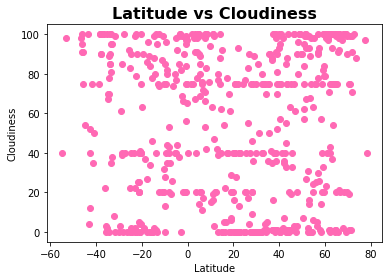

In [18]:
# Create scatter plot
plt.scatter(cityData_df.latitude, cityData_df.cloudiness, color="hotpink")

#Set title and labels 
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")
plt.title("Latitude vs Cloudiness", fontsize=16, fontweight="bold")
plt.show()

## Latitude vs. Wind Speed Plot

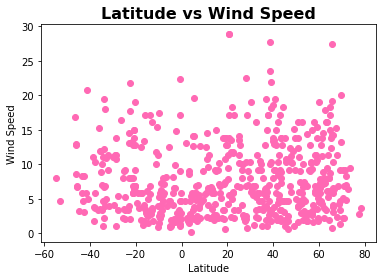

In [19]:
# Create scatter plot
plt.scatter(cityData_df.latitude, cityData_df.wind_speed, color="hotpink")

#Set title and labels 
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
plt.title("Latitude vs Wind Speed", fontsize=16, fontweight="bold")
plt.show()

## Linear Regression

In [21]:
# Create Northern and Southern Hemisphere DataFrames
# Filter by norther hemisphere 
northernHemi_mask = cityData_df.latitude >= 0
df_north = cityData_df.loc[northernHemi_mask].reset_index(drop=True)

df_north.head()

,cities,latitude,longitude,temperature,humidity,pressure,wind_speed,cloudiness
0,sirnak,37.52,42.46,48.09,50,1013,6.02,100
1,qaanaaq,77.48,-69.36,20.88,88,997,2.82,97
2,oktyabrskiy,54.48,53.47,39.49,69,1024,2.51,0
3,kodiak,57.79,-152.41,57.20,28,1003,16.11,1
4,khatanga,71.97,102.50,11.71,95,1017,6.98,99


In [23]:
# Filter by southern hemisphere 
southernHemi_mask = cityData_df.latitude < 0
df_south = cityData_df.loc[southernHemi_mask].reset_index(drop=True)

df_south.head()

,cities,latitude,longitude,temperature,humidity,pressure,wind_speed,cloudiness
0,bundaberg,-24.85,152.35,66.31,48,1021,9.17,90
1,atuona,-9.80,-139.03,82.04,73,1010,17.40,13
2,port elizabeth,-33.92,25.57,59.00,100,1025,4.70,90
3,taltal,-25.40,-70.48,59.61,76,1015,2.28,22
4,cape town,-33.93,18.42,54.61,87,1021,2.24,85


In [24]:
north_corrs = df_north.corr()
north_corrs

,latitude,longitude,temperature,humidity,pressure,wind_speed,cloudiness
latitude,1.000000,-0.012655,-0.886522,0.174247,0.163857,0.075598,0.124659
longitude,-0.012655,1.000000,-0.126430,0.264352,-0.108652,-0.314209,0.228251
temperature,-0.886522,-0.126430,1.000000,-0.360812,-0.215711,-0.007627,-0.218059
humidity,0.174247,0.264352,-0.360812,1.000000,-0.054864,-0.076424,0.348517
pressure,0.163857,-0.108652,-0.215711,-0.054864,1.000000,0.016249,-0.191009
wind_speed,0.075598,-0.314209,-0.007627,-0.076424,0.016249,1.000000,-0.019202
cloudiness,0.124659,0.228251,-0.218059,0.348517,-0.191009,-0.019202,1.000000


In [25]:
south_corrs = df_south.corr()
south_corrs

,latitude,longitude,temperature,humidity,pressure,wind_speed,cloudiness
latitude,1.000000,-0.086959,0.761999,0.106609,-0.037073,-0.194046,-0.022780
longitude,-0.086959,1.000000,0.014040,-0.091670,-0.104037,0.137196,0.060453
temperature,0.761999,0.014040,1.000000,0.123328,-0.181711,0.092349,0.011017
humidity,0.106609,-0.091670,0.123328,1.000000,-0.046974,-0.113118,0.281201
pressure,-0.037073,-0.104037,-0.181711,-0.046974,1.000000,-0.164562,-0.135540
wind_speed,-0.194046,0.137196,0.092349,-0.113118,-0.164562,1.000000,-0.017973
cloudiness,-0.022780,0.060453,0.011017,0.281201,-0.135540,-0.017973,1.000000


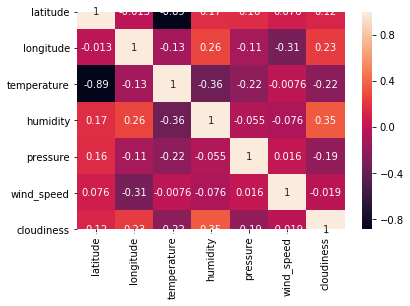

In [26]:
# Create heatmap of correlation for north hemesphire
sn.heatmap(north_corrs,annot = True,)

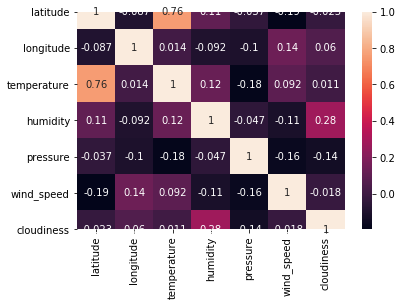

In [27]:
# Create heatmap of correlation for south hemesphire
sn.heatmap(south_corrs, annot = True)

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.7859217441524906
The p-value is: 1.3534032435509302e-130


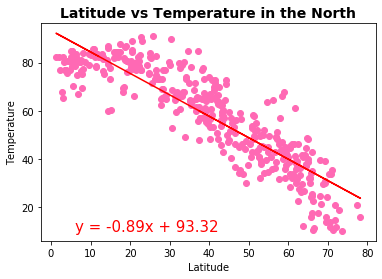

In [28]:
 # Print out the r-squared value along with the plot.
x_values = df_north['latitude']
y_values = df_north['temperature']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values, color="hotpink")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Temperature')
plt.title("Latitude vs Temperature in the North", fontsize=14, fontweight="bold")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.5806430800562504
The p-value is: 3.1068317962213934e-35


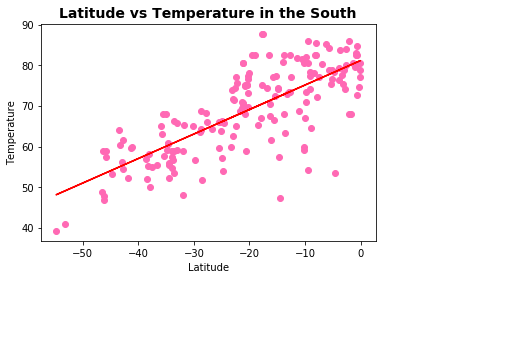

In [48]:
 # Print out the r-squared value along with the plot.
x_values = df_south['latitude']
y_values = df_south['temperature']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values, color="hotpink")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="green")
plt.xlabel('Latitude')
plt.ylabel('Temperature')
plt.title("Latitude vs Temperature in the South", fontsize=14, fontweight="bold")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.03036189240098759
The p-value is: 0.0005846392929933197


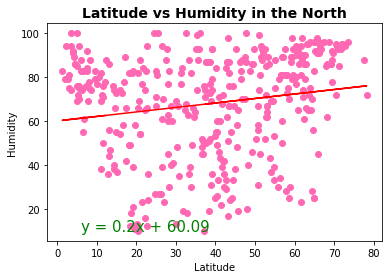

In [47]:
 # Print out the r-squared value along with the plot.
x_values = df_north['latitude']
y_values = df_north['humidity']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values,color="hotpink")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="green")
plt.xlabel('Latitude')
plt.ylabel('Humidity')
plt.title("Latitude vs Humidity in the North", fontsize=14, fontweight="bold")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.011365391541768325
The p-value is: 0.15549581642541246


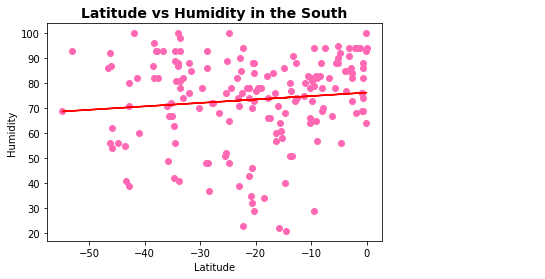

In [31]:
# Print out the r-squared value along with the plot.
x_values = df_south['latitude']
y_values = df_south['humidity']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values, color="hotpink")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="green")
plt.xlabel('Latitude')
plt.ylabel('Humidity')
plt.title("Latitude vs Humidity in the South", fontsize=14, fontweight="bold")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.015539969939669504
The p-value is: 0.01425420053235093


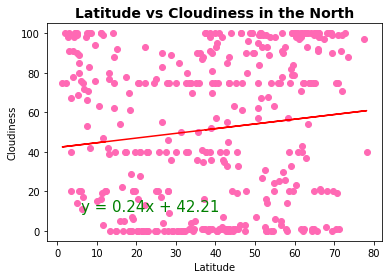

In [41]:
# Print out the r-squared value along with the plot.
x_values = df_north['latitude']
y_values = df_north['cloudiness']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values, color="hotpink")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="green")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness')
plt.title("Latitude vs Cloudiness in the North", fontsize=14, fontweight="bold")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.0005189358121947857
The p-value is: 0.7621323047326366


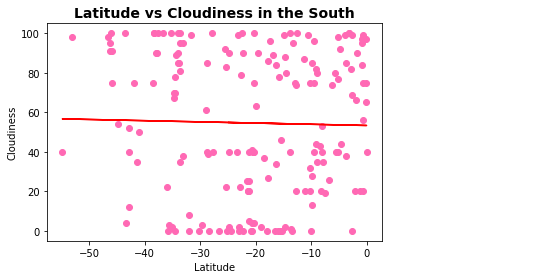

In [43]:
# Print out the r-squared value along with the plot.
x_values = df_south['latitude']
y_values = df_south['cloudiness']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values, color="hotpink")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="green")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness')
plt.title("Latitude vs Cloudiness in the South", fontsize=14, fontweight="bold")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.005715123394415107
The p-value is: 0.13818633644000564


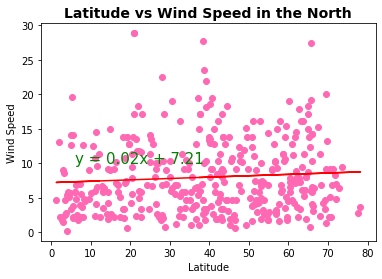

In [45]:
# Print out the r-squared value along with the plot.
x_values = df_north['latitude']
y_values = df_north['wind_speed']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values, color="hotpink")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15, color="green")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed')
plt.title("Latitude vs Wind Speed in the North", fontsize=14, fontweight="bold")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.03765397803644496
The p-value is: 0.009247608315863994


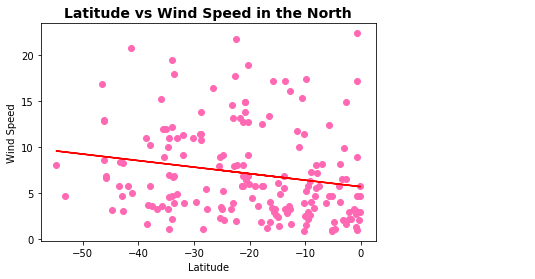

In [46]:
# Print out the r-squared value along with the plot.
x_values = df_south['latitude']
y_values = df_south['wind_speed']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values, color="hotpink")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="green")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed')
plt.title("Latitude vs Wind Speed in the North", fontsize=14, fontweight="bold")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")
plt.show()

In [ ]:
# Actual Regression Analysis

In [36]:
import statsmodels.api as sm

In [37]:
X = df_north[["latitude", "pressure", "cloudiness", "wind_speed"]]
y = df_north[["temperature"]]

In [38]:
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

C:\Users\anagi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     406.8
Date:                Sun, 03 May 2020   Prob (F-statistic):          4.78e-136
Time:                        19:11:22   Log-Likelihood:                -1386.6
No. Observations:                 386   AIC:                             2783.
Df Residuals:                     381   BIC:                             2803.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        412.7044     73.310      5.630      0.000     268.561     556.848
latitude      -0.8610      0.023    -37.328      0.000      -0.906      -0.816
pressure      -0.3150      0.072     -4.346      0.000      -0.457      -0.172
cloudiness    -0.0678      0.012     -5.608      0.000      -0.092      -0.044
wind_speed     0.2152      0.085      2.519      0.012       0.047       0.383
==============================================================================
Omnibus:                        1.274   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.529   Jarque-Bera (JB):                1.261
Skew:                          -0.139   Prob(JB):                        0.532
Kurtosis:                       2.963   Cond. No.                     1.65e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

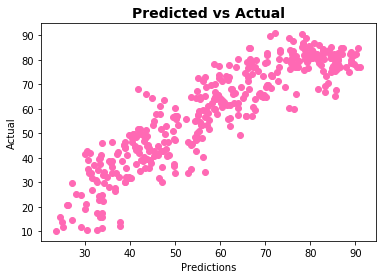

In [39]:
plt.scatter(predictions, y, color="hotpink")
plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.title("Predicted vs Actual", fontsize=14, fontweight="bold")
plt.show()

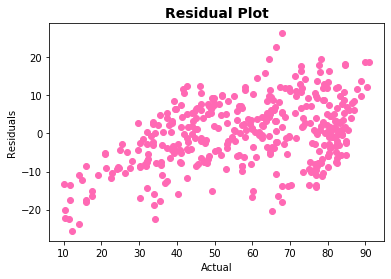

In [40]:
residuals = y.temperature - predictions

plt.scatter(y, residuals, color="hotpink")
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.title("Residual Plot", fontsize=14, fontweight="bold")
plt.show()